**Hierarchical** CNN (HCNN) for Text Classification

 Install Required Libraries

In [ ]:
!pip install tensorflow keras pandas scikit-learn -q

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load and Explore Data

Dataset shape: (30000, 3)

Columns: ['text', 'category', 'label']

First few rows:
                                                text       category  label
0  ethan hawke julie delpy pick left midnight eth...  ENTERTAINMENT      3
1  tom cruise forced choose scientology suri tom ...  ENTERTAINMENT      3
2  would pay wine beer glass made cheese heart me...  ENTERTAINMENT      3
3                    tyga denies dating kylie jenner  ENTERTAINMENT      3
4  review laughfest subversively family friendly ...  ENTERTAINMENT      3

Unique categories: 15

Label distribution:
label
0     2000
1     2000
2     2000
3     2000
4     2000
5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
13    2000
14    2000
Name: count, dtype: int64

Text length statistics:
count    30000.000000
mean        17.633600
std          7.196968
min          5.000000
25%         13.000000
50%         17.000000
75%         22.000000
max        108.000000
Name: text_length, dtype:

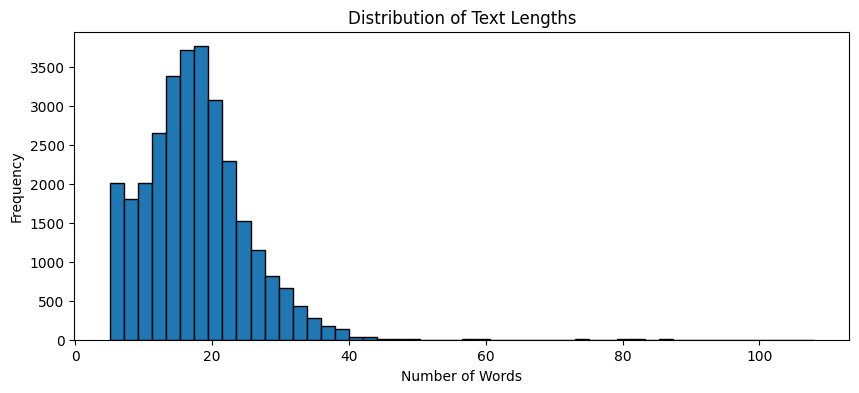

In [ ]:
# Load data
df = pd.read_csv('news_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nUnique categories: {df['category'].nunique()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

# Check text lengths
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
print(f"\nText length statistics:")
print(df['text_length'].describe())

plt.figure(figsize=(10, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

Prepare Data for HCNN

In [ ]:
# Parameters
MAX_WORDS = 10000        # Vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Max number of words per text
EMBEDDING_DIM = 100      # Word embedding dimension

# Prepare texts and labels
texts = df['text'].astype(str).tolist()
labels = df['label'].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 24000
Validation samples: 3000
Test samples: 3000


Save Data Splits

In [ ]:
# Save data splits
data_splits = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
}

with open('data_splits.pkl', 'wb') as f:
    pickle.dump(data_splits, f)

print("✅ Data splits saved as 'data_splits.pkl'")

✅ Data splits saved as 'data_splits.pkl'


Tokenization and Padding

In [ ]:
# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train_pad.shape}")

# Get number of classes
num_classes = len(np.unique(labels))
print(f"Number of classes: {num_classes}")

Vocabulary size: 30903
Training data shape: (24000, 200)
Number of classes: 15


 Build Hierarchical CNN Architecture

In [ ]:
def build_hcnn(vocab_size, embedding_dim, max_length, num_classes):
    """
    Hierarchical CNN Architecture:
    - Embedding layer
    - Multiple parallel CNN layers with different filter sizes (capturing different n-grams)
    - Max pooling
    - Dense layers for classification
    """

    # Input
    input_layer = layers.Input(shape=(max_length,))

    # Embedding layer
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    )(input_layer)

    # Dropout after embedding
    embedding = layers.Dropout(0.2)(embedding)

    # Multiple CNN branches with different kernel sizes
    # This captures different n-gram patterns (unigrams, bigrams, trigrams, etc.)

    # Branch 1: Kernel size 2 (bigrams)
    conv1 = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(embedding)
    conv1 = layers.GlobalMaxPooling1D()(conv1)

    # Branch 2: Kernel size 3 (trigrams)
    conv2 = layers.Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
    conv2 = layers.GlobalMaxPooling1D()(conv2)

    # Branch 3: Kernel size 4 (4-grams)
    conv3 = layers.Conv1D(filters=128, kernel_size=4, activation='relu')(embedding)
    conv3 = layers.GlobalMaxPooling1D()(conv3)

    # Branch 4: Kernel size 5 (5-grams)
    conv4 = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
    conv4 = layers.GlobalMaxPooling1D()(conv4)

    # Concatenate all branches
    merged = layers.Concatenate()([conv1, conv2, conv3, conv4])

    # Dense layers
    dense1 = layers.Dense(256, activation='relu')(merged)
    dense1 = layers.Dropout(0.5)(dense1)

    dense2 = layers.Dense(128, activation='relu')(dense1)
    dense2 = layers.Dropout(0.3)(dense2)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(dense2)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output)

    return model

# Build the model
model = build_hcnn(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes
)

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 100)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 199, 128)  │     25,728 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 198, 128)  │     38,528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 197, 128)  │     51,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 196, 128)  │     64,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 15)        │      1,935 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,345,871 (5.13 MB)

 Trainable params: 1,345,871 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

Compile the Model

In [ ]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")

✅ Model compiled successfully!


Setup Callbacks

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_hcnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

Train the Model

In [ ]:
# Train
print("🚀 Starting training...\n")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

🚀 Starting training...

Epoch 1/20
369/375 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1050 - loss: 2.6400
Epoch 1: val_accuracy improved from -inf to 0.50100, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.1068 - loss: 2.6359 - val_accuracy: 0.5010 - val_loss: 1.7069 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5142 - loss: 1.5821
Epoch 2: val_accuracy improved from 0.50100 to 0.59833, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5143 - loss: 1.5819 - val_accuracy: 0.5983 - val_loss: 1.4162 - learning_rate: 0.0010
Epoch 3/20
371/375 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6849 - loss: 1.0733
Epoch 3: val_accuracy improved from 0.59833 to 0.60200, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6847 - loss: 1.0737 - val_accuracy: 0.6020 - val_loss: 1.4136 - learning_rate: 0.0010
Epoch 4/20
370/375 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7675 - loss: 0.7943
Epoch 4: val_accuracy did not improve from 0.60200
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7674 - loss: 0.7949 - val_accuracy: 0.5907 - val_loss: 1.5642 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8285 - loss: 0.5855
Epoch 5: val_accuracy did not improve from 0.60200
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8285 - loss: 0.5856 - val_accuracy: 0.5893 - val_loss: 1.7431 - learning_rate: 0.0010
Epoch 6/20
370/375 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8731 - loss: 0.4242
Epoch 6: val_accuracy did not improve from 0.60200

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8729 - loss: 0.4248 - val_accurac

Plot Training History

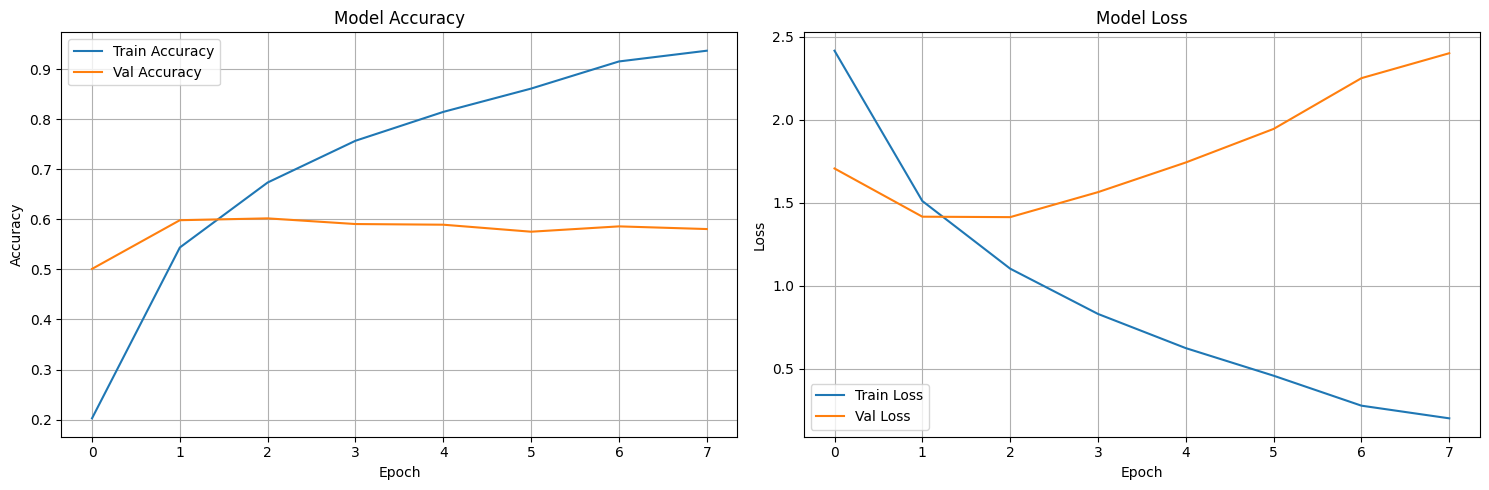

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Evaluate on Test Set

In [ ]:
# Load best model
model.load_weights('best_hcnn_model.h5')

# Predict on test set
print("📊 Evaluating on test set...\n")
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred_probs = model.predict(X_test_pad, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred))

📊 Evaluating on test set...

Test Loss: 1.3774
Test Accuracy: 0.5967 (59.67%)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       200
           1       0.52      0.56      0.54       200
           2       0.61      0.73      0.67       200
           3       0.45      0.38      0.41       200
           4       0.62      0.58      0.60       200
           5       0.62      0.80      0.70       200
           6       0.58      0.40      0.47       200
           7       0.59      0.58      0.59       200
           8       0.54      0.64      0.58       200
           9       0.80      0.77      0.78       200
          10       0.71      0.72      0.72       200
          11       0.65      0.67      0.66       200
          12       0.53      0.56      0.54       200
          13       0.46      0.51      0.48       200
          14       0.67      0.59      0.63       200

    accuracy         

Confusion Matrix

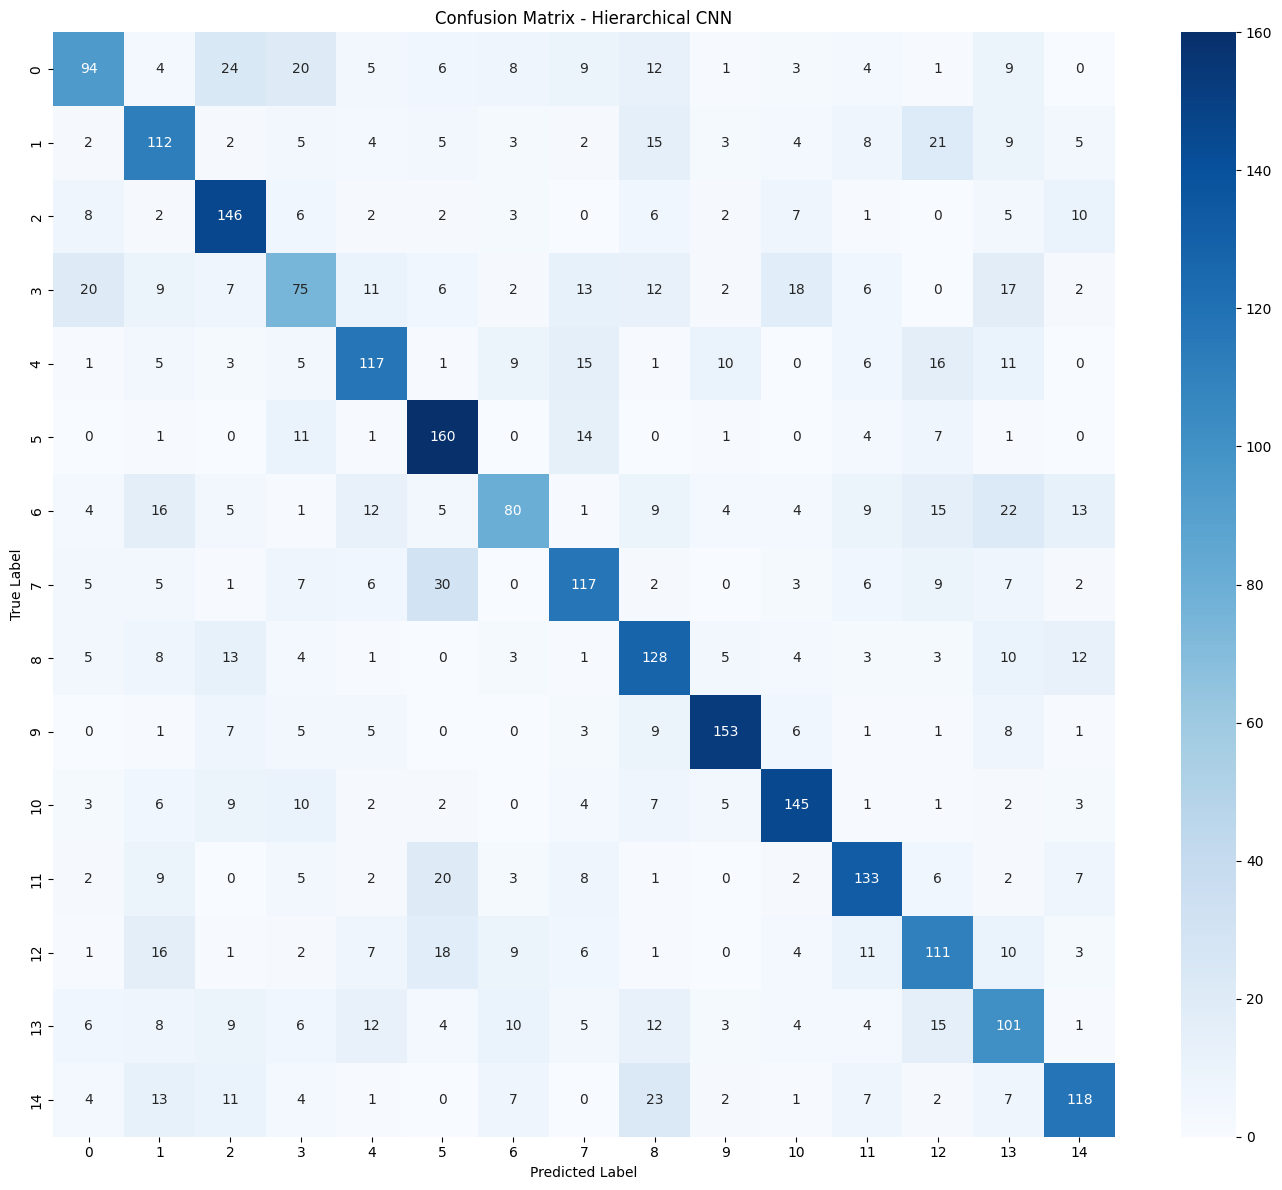


Per-class Accuracy:
Class 0: 0.4700 (47.00%)
Class 1: 0.5600 (56.00%)
Class 2: 0.7300 (73.00%)
Class 3: 0.3750 (37.50%)
Class 4: 0.5850 (58.50%)
Class 5: 0.8000 (80.00%)
Class 6: 0.4000 (40.00%)
Class 7: 0.5850 (58.50%)
Class 8: 0.6400 (64.00%)
Class 9: 0.7650 (76.50%)
Class 10: 0.7250 (72.50%)
Class 11: 0.6650 (66.50%)
Class 12: 0.5550 (55.50%)
Class 13: 0.5050 (50.50%)
Class 14: 0.5900 (59.00%)


In [ ]:
# Confusion matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Hierarchical CNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc:.4f} ({acc*100:.2f}%)")

Save Model and Preprocessing Objects

In [ ]:
# Save the model
model.save('hcnn_news_classifier.h5')
print("✅ Model saved as 'hcnn_news_classifier.h5'")

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as 'tokenizer.pkl'")

# Save label mapping
label_mapping = df[['category', 'label']].drop_duplicates().sort_values('label')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)
print("✅ Label encoder saved as 'label_encoder.pkl'")

# Save config
config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'num_classes': num_classes
}
with open('hcnn_config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("✅ Config saved as 'hcnn_config.pkl'")

✅ Model saved as 'hcnn_news_classifier.h5'
✅ Tokenizer saved as 'tokenizer.pkl'
✅ Label encoder saved as 'label_encoder.pkl'
✅ Config saved as 'hcnn_config.pkl'


Test Predictions

In [ ]:
def predict_text(text, model, tokenizer, label_mapping, max_length):
    """Predict category for a given text"""

    # Preprocess
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded, verbose=0)
    pred_label = np.argmax(prediction[0])
    confidence = prediction[0][pred_label]

    # Get category name
    category = label_mapping[label_mapping['label'] == pred_label]['category'].values[0]

    print(f"Text: {text[:100]}...")
    print(f"Predicted Category: {category}")
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"Top 3 predictions:")
    top_3_idx = np.argsort(prediction[0])[-3:][::-1]
    for idx in top_3_idx:
        cat = label_mapping[label_mapping['label'] == idx]['category'].values[0]
        print(f"  - {cat}: {prediction[0][idx]*100:.2f}%")
    print()

# Test with examples
predict_text("The Lakers won the championship game last night", model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)
predict_text("New study shows benefits of meditation for mental health", model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)
predict_text("Stock market reaches all-time high today", model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)
predict_text("Tips for healthy eating and meal preparation", model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)

Text: The Lakers won the championship game last night...
Predicted Category: SPORTS
Confidence: 99.48%
Top 3 predictions:
  - SPORTS: 99.48%
  - ENTERTAINMENT: 0.29%
  - BLACK_VOICES: 0.07%

Text: New study shows benefits of meditation for mental health...
Predicted Category: WELLNESS
Confidence: 94.44%
Top 3 predictions:
  - WELLNESS: 94.44%
  - BUSINESS: 2.21%
  - IMPACT: 0.84%

Text: Stock market reaches all-time high today...
Predicted Category: FOOD
Confidence: 30.47%
Top 3 predictions:
  - FOOD: 30.47%
  - LIFESTYLE: 16.30%
  - BUSINESS: 15.51%

Text: Tips for healthy eating and meal preparation...
Predicted Category: FOOD
Confidence: 84.43%
Top 3 predictions:
  - FOOD: 84.43%
  - LIFESTYLE: 8.60%
  - WELLNESS: 3.40%



Load Model Later (For Future Use)

In [ ]:
# Load everything back
from tensorflow import keras
import pickle

# Load model
loaded_model = keras.models.load_model('hcnn_news_classifier.h5')

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)

# Load label mapping
with open('label_encoder.pkl', 'rb') as f:
    loaded_label_mapping = pickle.load(f)

# Load config
with open('hcnn_config.pkl', 'rb') as f:
    loaded_config = pickle.load(f)

print("✅ All components loaded successfully!")

# Now you can use predict_text with loaded objects
predict_text(
    "Breaking news about political developments",
    loaded_model,
    loaded_tokenizer,
    loaded_label_mapping,
    loaded_config['MAX_SEQUENCE_LENGTH']
)

✅ All components loaded successfully!
Text: Breaking news about political developments...
Predicted Category: POLITICS
Confidence: 31.86%
Top 3 predictions:
  - POLITICS: 31.86%
  - WORLDPOST: 15.72%
  - ENTERTAINMENT: 14.47%



# Improve the accuracy of the text classification model by implementing a new model architecture that uses pre-trained GloVe embeddings and an attention layer


## Download and load glove embeddings


Downloading the pre-trained GloVe embeddings and load them into a dictionary.


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -q
!unzip -q glove.6B.zip


 the GloVe embeddings are downloaded and unzipped, loading the 100-dimensional embeddings into a dictionary.



In [ ]:
glove_dir = '.' # Directory where the unzipped files are located
embeddings_index = {}
with open(f'{glove_dir}/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


## Creating embedding matrix


Create an embedding matrix using the GloVe embeddings and the tokenizer's word index.



Create the embedding matrix based on the tokenizer's word index and the loaded GloVe embeddings.



In [ ]:
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (10000, 100)


## Build hcnn model with glove and attention

### Subtask:
Build a new Hierarchical CNN model architecture, incorporating the GloVe embedding layer and adding an attention layer.


**Reasoning**:
Define the Hierarchical CNN model with GloVe embedding and an attention layer, and then build and summarize the model.



In [ ]:
def build_hcnn_glove_attention(vocab_size, embedding_dim, max_length, num_classes, embedding_matrix):
    """
    Hierarchical CNN Architecture with GloVe Embedding and Attention:
    - Embedding layer initialized with GloVe weights (non-trainable)
    - Multiple parallel CNN layers with different filter sizes
    - Global Max Pooling
    - Attention mechanism
    - Dense layers for classification
    """

    # Input
    input_layer = layers.Input(shape=(max_length,))

    # Embedding layer with pre-trained GloVe weights
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=False  # Keep embeddings fixed
    )(input_layer)

    # Dropout after embedding
    embedding = layers.Dropout(0.2)(embedding)

    # Multiple CNN branches with different kernel sizes
    conv_branches = []
    for kernel_size in [2, 3, 4, 5]:
        conv = layers.Conv1D(filters=128, kernel_size=kernel_size, activation='relu')(embedding)
        pool = layers.GlobalMaxPooling1D()(conv)
        conv_branches.append(pool)

    # Concatenate all branches
    merged = layers.Concatenate()(conv_branches)

    # Add Attention mechanism
    # Using a simple Self-Attention mechanism
    attention_output = layers.Attention()([merged, merged])


    # Dense layers
    dense1 = layers.Dense(256, activation='relu')(attention_output)
    dense1 = layers.Dropout(0.5)(dense1)

    dense2 = layers.Dense(128, activation='relu')(dense1)
    dense2 = layers.Dropout(0.3)(dense2)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(dense2)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output)

    return model

# Build the new model
model_glove_attention = build_hcnn_glove_attention(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix
)

# Display model architecture
model_glove_attention.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 100)  │  1,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 200, 100)  │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 199, 128)  │     25,728 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 198, 128)  │     38,528 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 197, 128)  │     51,328 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 196, 128)  │     64,128 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_6[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_7[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 512)       │          0 │ concatenate_1[0]… │
│ (Attention)         │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 15)        │      1,935 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,345,871 (5.13 MB)

 Trainable params: 345,871 (1.32 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

## Compile the new model


Compiling the new model with an appropriate optimizer, loss function, and metrics.


In [ ]:
# Compile the new model
model_glove_attention.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ New model with GloVe and Attention compiled successfully!")

✅ New model with GloVe and Attention compiled successfully!


## Train the new model


Train the new model using the prepared data and callbacks.



Training the new model using the prepared data and callbacks.



In [ ]:
from tensorflow.keras import layers, models
import numpy as np

def build_hcnn_glove_attention_fixed(vocab_size, embedding_dim, max_length, num_classes, embedding_matrix):
    """
    Hierarchical CNN Architecture with GloVe Embedding and Attention:
    - Embedding layer initialized with GloVe weights (non-trainable)
    - Attention mechanism applied after embedding
    - Multiple parallel CNN layers with different filter sizes (capturing different n-grams)
    - Global Max Pooling
    - Dense layers for classification
    """

    # Input
    input_layer = layers.Input(shape=(max_length,))

    # Embedding layer with pre-trained GloVe weights
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=False  # Keep embeddings fixed
    )(input_layer)

    # Dropout after embedding
    embedding = layers.Dropout(0.2)(embedding)

    # Add Self-Attention mechanism after embedding
    # Attention layer expects input shape (batch_size, sequence_length, features)
    attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(embedding, embedding)
    attention_output = layers.Dropout(0.2)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    attention_output = layers.Add()([embedding, attention_output]) # Add residual connection

    # Multiple CNN branches with different kernel sizes
    # These branches now process the attention-weighted embeddings
    conv_branches = []
    for kernel_size in [2, 3, 4, 5]:
        conv = layers.Conv1D(filters=128, kernel_size=kernel_size, activation='relu')(attention_output)
        pool = layers.GlobalMaxPooling1D()(conv)
        conv_branches.append(pool)

    # Concatenate all branches
    merged = layers.Concatenate()(conv_branches)

    # Dense layers
    dense1 = layers.Dense(256, activation='relu')(merged)
    dense1 = layers.Dropout(0.5)(dense1)

    dense2 = layers.Dense(128, activation='relu')(dense1)
    dense2 = layers.Dropout(0.3)(dense2)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(dense2)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output)

    return model

# Build the fixed model
model_glove_attention = build_hcnn_glove_attention_fixed(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix
)

# Compile the fixed model
model_glove_attention.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_glove_attention.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 200, 100)  │  1,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 200, 100)  │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 100)  │    322,500 │ dropout_6[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 200, 100)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 100)  │        200 │ dropout_8[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 100)  │          0 │ dropout_6[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 199, 128)  │     25,728 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 198, 128)  │     38,528 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 197, 128)  │     51,328 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 196, 128)  │     64,128 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_8[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_9[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    131,328 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dropout_9[0][0] 

 Total params: 1,668,571 (6.37 MB)

 Trainable params: 668,571 (2.55 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

**Training The New Model**:




In [ ]:
# Train the new model
print("🚀 Starting training for GloVe + Attention model...\n")

history_glove_attention = model_glove_attention.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training of GloVe + Attention model complete!")

🚀 Starting training for GloVe + Attention model...

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7024 - loss: 0.9985
Epoch 1: val_accuracy improved from 0.64367 to 0.64900, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7024 - loss: 0.9985 - val_accuracy: 0.6490 - val_loss: 1.2117 - learning_rate: 5.0000e-04
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7067 - loss: 0.9799
Epoch 2: val_accuracy did not improve from 0.64900
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7067 - loss: 0.9799 - val_accuracy: 0.6467 - val_loss: 1.2267 - learning_rate: 5.0000e-04
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7049 - loss: 0.9602
Epoch 3: val_accuracy did not improve from 0.64900
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7049 - loss: 0.9602 - val_accuracy: 0.6437 - val_loss: 1.2278 - learning_rate: 5.0000e-04
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7183 - loss: 0.9340
Epoch 4: val_accuracy did not improve from 0.64900

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7183 - loss

375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7191 - loss: 0.9248 - val_accuracy: 0.6493 - val_loss: 1.2343 - learning_rate: 2.5000e-04
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7280 - loss: 0.8926
Epoch 6: val_accuracy improved from 0.64933 to 0.65233, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7280 - loss: 0.8925 - val_accuracy: 0.6523 - val_loss: 1.2360 - learning_rate: 2.5000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

✅ Training of GloVe + Attention model complete!


## Evaluate the new model


Evaluating the trained model on the test set and display the classification report and confusion matrix.

In [ ]:
# Load the best weights from the training of the new model
model_glove_attention.load_weights('best_hcnn_model.h5')

# Predict on test set using the new model
print("📊 Evaluating new model on test set...\n")
test_loss_glove, test_accuracy_glove = model_glove_attention.evaluate(X_test_pad, y_test, verbose=0)

print(f"New Model Test Loss: {test_loss_glove:.4f}")
print(f"New Model Test Accuracy: {test_accuracy_glove:.4f} ({test_accuracy_glove*100:.2f}%)")

# Get predictions for the new model
y_pred_probs_glove = model_glove_attention.predict(X_test_pad, verbose=0)
y_pred_glove = np.argmax(y_pred_probs_glove, axis=1)

# Classification report for the new model
print("\n📋 Detailed Classification Report (New Model):")
print(classification_report(y_test, y_pred_glove))

📊 Evaluating new model on test set...

New Model Test Loss: 1.2000
New Model Test Accuracy: 0.6563 (65.63%)

📋 Detailed Classification Report (New Model):
              precision    recall  f1-score   support

           0       0.62      0.45      0.52       200
           1       0.65      0.61      0.63       200
           2       0.68      0.84      0.75       200
           3       0.51      0.53      0.52       200
           4       0.62      0.68      0.65       200
           5       0.67      0.85      0.75       200
           6       0.62      0.36      0.45       200
           7       0.67      0.60      0.64       200
           8       0.68      0.56      0.62       200
           9       0.84      0.78      0.81       200
          10       0.77      0.77      0.77       200
          11       0.73      0.76      0.75       200
          12       0.53      0.72      0.61       200
          13       0.58      0.57      0.58       200
          14       0.71      0.76 

## Visualize training history comparison


Plot the training and validation accuracy and loss for both models on the same graphs to visually compare their learning curves.


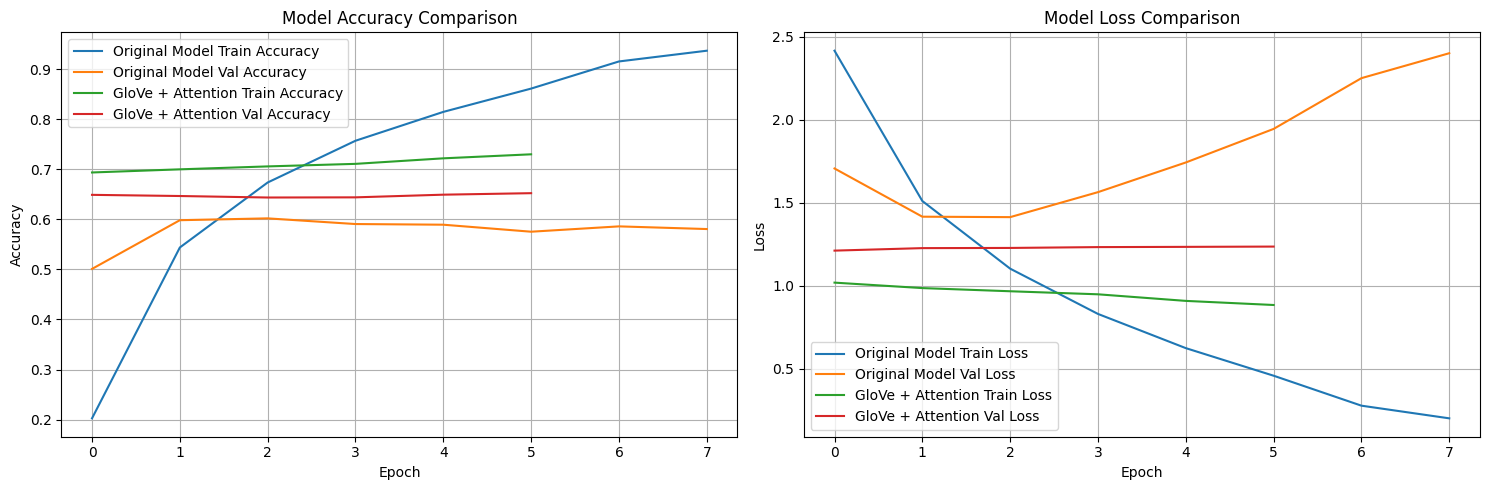

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Original Model Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Original Model Val Accuracy')
axes[0].plot(history_glove_attention.history['accuracy'], label='GloVe + Attention Train Accuracy')
axes[0].plot(history_glove_attention.history['val_accuracy'], label='GloVe + Attention Val Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Original Model Train Loss')
axes[1].plot(history.history['val_loss'], label='Original Model Val Loss')
axes[1].plot(history_glove_attention.history['loss'], label='GloVe + Attention Train Loss')
axes[1].plot(history_glove_attention.history['val_loss'], label='GloVe + Attention Val Loss')
axes[1].set_title('Model Loss Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Visualize classification report comparison


Creating bar plots to compare the precision, recall, and F1-score for each class between the two models.


In [ ]:
import io

# Classification report for the original model (from previous output)
report_original_text = """
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       200
           1       0.52      0.56      0.54       200
           2       0.61      0.73      0.67       200
           3       0.45      0.38      0.41       200
           4       0.62      0.58      0.60       200
           5       0.62      0.80      0.70       200
           6       0.58      0.40      0.47       200
           7       0.59      0.58      0.59       200
           8       0.54      0.64      0.58       200
           9       0.80      0.77      0.78       200
          10       0.71      0.72      0.72       200
          11       0.65      0.67      0.66       200
          12       0.53      0.56      0.54       200
          13       0.46      0.51      0.48       200
          14       0.67      0.59      0.63       200

    accuracy                           0.60      3000
   macro avg       0.60      0.60      0.59      3000
weighted avg       0.60      0.60      0.59      3000
"""

# Classification report for the new model (GloVe + Attention) (from previous output)
report_glove_attention_text = """
              precision    recall  f1-score   support

           0       0.62      0.45      0.52       200
           1       0.65      0.61      0.63       200
           2       0.68      0.84      0.75       200
           3       0.51      0.53      0.52       200
           4       0.62      0.68      0.65       200
           5       0.67      0.85      0.75       200
           6       0.62      0.36      0.45       200
           7       0.67      0.60      0.64       200
           8       0.68      0.56      0.62       200
           9       0.84      0.78      0.81       200
          10       0.77      0.77      0.77       200
          11       0.73      0.76      0.75       200
          12       0.53      0.72      0.61       200
          13       0.58      0.57      0.58       200
          14       0.71      0.76      0.73       200

    accuracy                           0.66      3000
   macro avg       0.66      0.66      0.65      3000
weighted avg       0.66      0.66      0.65      3000
"""

# Function to parse classification report text
def parse_classification_report(report_text):
    report_data = []
    lines = report_text.strip().split('\n')
    # Skip header and accuracy/macro/weighted averages
    for line in lines[2:-3]:
        parts = line.split()
        if len(parts) == 5:
            class_label = int(parts[0])
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])
            report_data.append([class_label, precision, recall, f1_score, support])
    return pd.DataFrame(report_data, columns=['label', 'precision', 'recall', 'f1-score', 'support'])

# Parse reports into DataFrames
report_original_df = parse_classification_report(report_original_text)
report_glove_attention_df = parse_classification_report(report_glove_attention_text)

# Merge with category names
report_original_df = pd.merge(report_original_df, label_mapping, on='label')
report_glove_attention_df = pd.merge(report_glove_attention_df, label_mapping, on='label')

display("Original Model Report:")
display(report_original_df)
display("\nGloVe + Attention Model Report:")
display(report_glove_attention_df)

'Original Model Report:'

,label,precision,recall,f1-score,support,category
0,0,0.61,0.47,0.53,200,BLACK_VOICES
1,1,0.52,0.56,0.54,200,BUSINESS
2,2,0.61,0.73,0.67,200,CRIME
3,3,0.45,0.38,0.41,200,ENTERTAINMENT
4,4,0.62,0.58,0.60,200,FAMILY
5,5,0.62,0.80,0.70,200,FOOD
6,6,0.58,0.40,0.47,200,IMPACT
7,7,0.59,0.58,0.59,200,LIFESTYLE
8,8,0.54,0.64,0.58,200,POLITICS
9,9,0.80,0.77,0.78,200,QUEER_VOICES


'\nGloVe + Attention Model Report:'

,label,precision,recall,f1-score,support,category
0,0,0.62,0.45,0.52,200,BLACK_VOICES
1,1,0.65,0.61,0.63,200,BUSINESS
2,2,0.68,0.84,0.75,200,CRIME
3,3,0.51,0.53,0.52,200,ENTERTAINMENT
4,4,0.62,0.68,0.65,200,FAMILY
5,5,0.67,0.85,0.75,200,FOOD
6,6,0.62,0.36,0.45,200,IMPACT
7,7,0.67,0.60,0.64,200,LIFESTYLE
8,8,0.68,0.56,0.62,200,POLITICS
9,9,0.84,0.78,0.81,200,QUEER_VOICES


**Create bar plots to compare precision, recall, and F1-score for each class between the two models using the parsed dataframes.**:




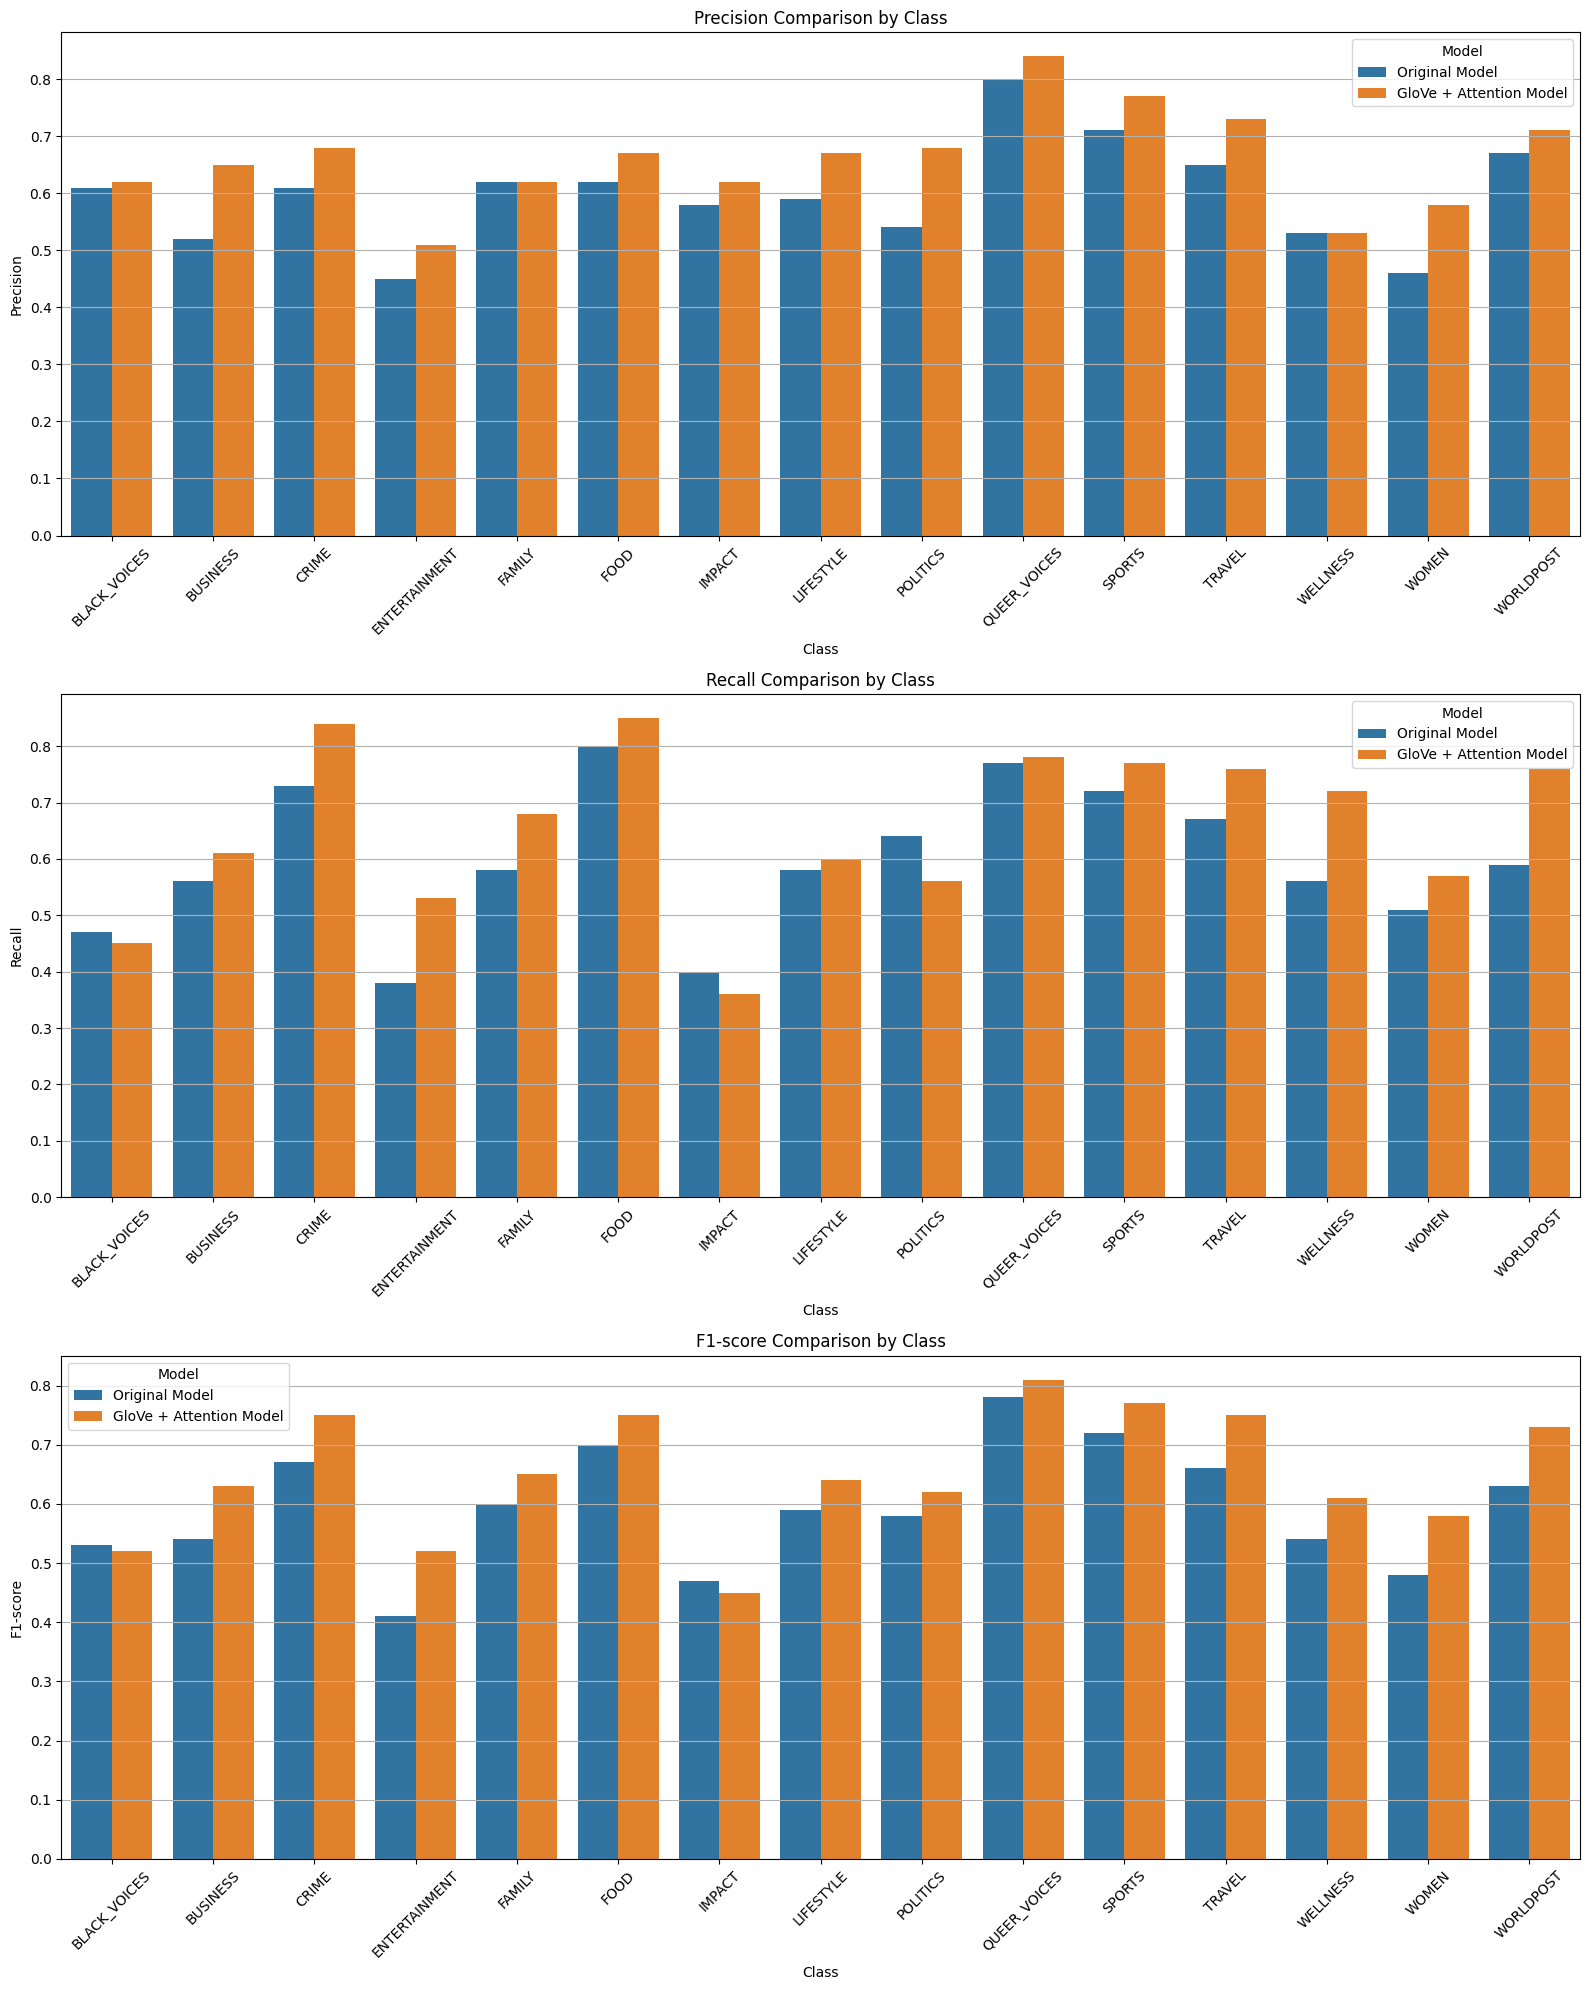

In [ ]:
# Prepare data for plotting
plot_data_precision = pd.DataFrame({
    'category': report_original_df['category'],
    'Original Model': report_original_df['precision'],
    'GloVe + Attention Model': report_glove_attention_df['precision']
})

plot_data_recall = pd.DataFrame({
    'category': report_original_df['category'],
    'Original Model': report_original_df['recall'],
    'GloVe + Attention Model': report_glove_attention_df['recall']
})

plot_data_f1 = pd.DataFrame({
    'category': report_original_df['category'],
    'Original Model': report_original_df['f1-score'],
    'GloVe + Attention Model': report_glove_attention_df['f1-score']
})

# Melt dataframes for seaborn plotting
plot_data_precision_melted = plot_data_precision.melt(id_vars='category', var_name='Model', value_name='Precision')
plot_data_recall_melted = plot_data_recall.melt(id_vars='category', var_name='Model', value_name='Recall')
plot_data_f1_melted = plot_data_f1.melt(id_vars='category', var_name='Model', value_name='F1-score')

# Create the plots
fig, axes = plt.subplots(3, 1, figsize=(16, 20))

# Precision plot
sns.barplot(x='category', y='Precision', hue='Model', data=plot_data_precision_melted, ax=axes[0])
axes[0].set_title('Precision Comparison by Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Precision')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

# Recall plot
sns.barplot(x='category', y='Recall', hue='Model', data=plot_data_recall_melted, ax=axes[1])
axes[1].set_title('Recall Comparison by Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')

# F1-score plot
sns.barplot(x='category', y='F1-score', hue='Model', data=plot_data_f1_melted, ax=axes[2])
axes[2].set_title('F1-score Comparison by Class')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('F1-score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y')


plt.tight_layout()
plt.show()

## Confusion matrix comparison





displaying the confusion matrices for both models side-by-side for a direct visual comparison of their misclassifications.



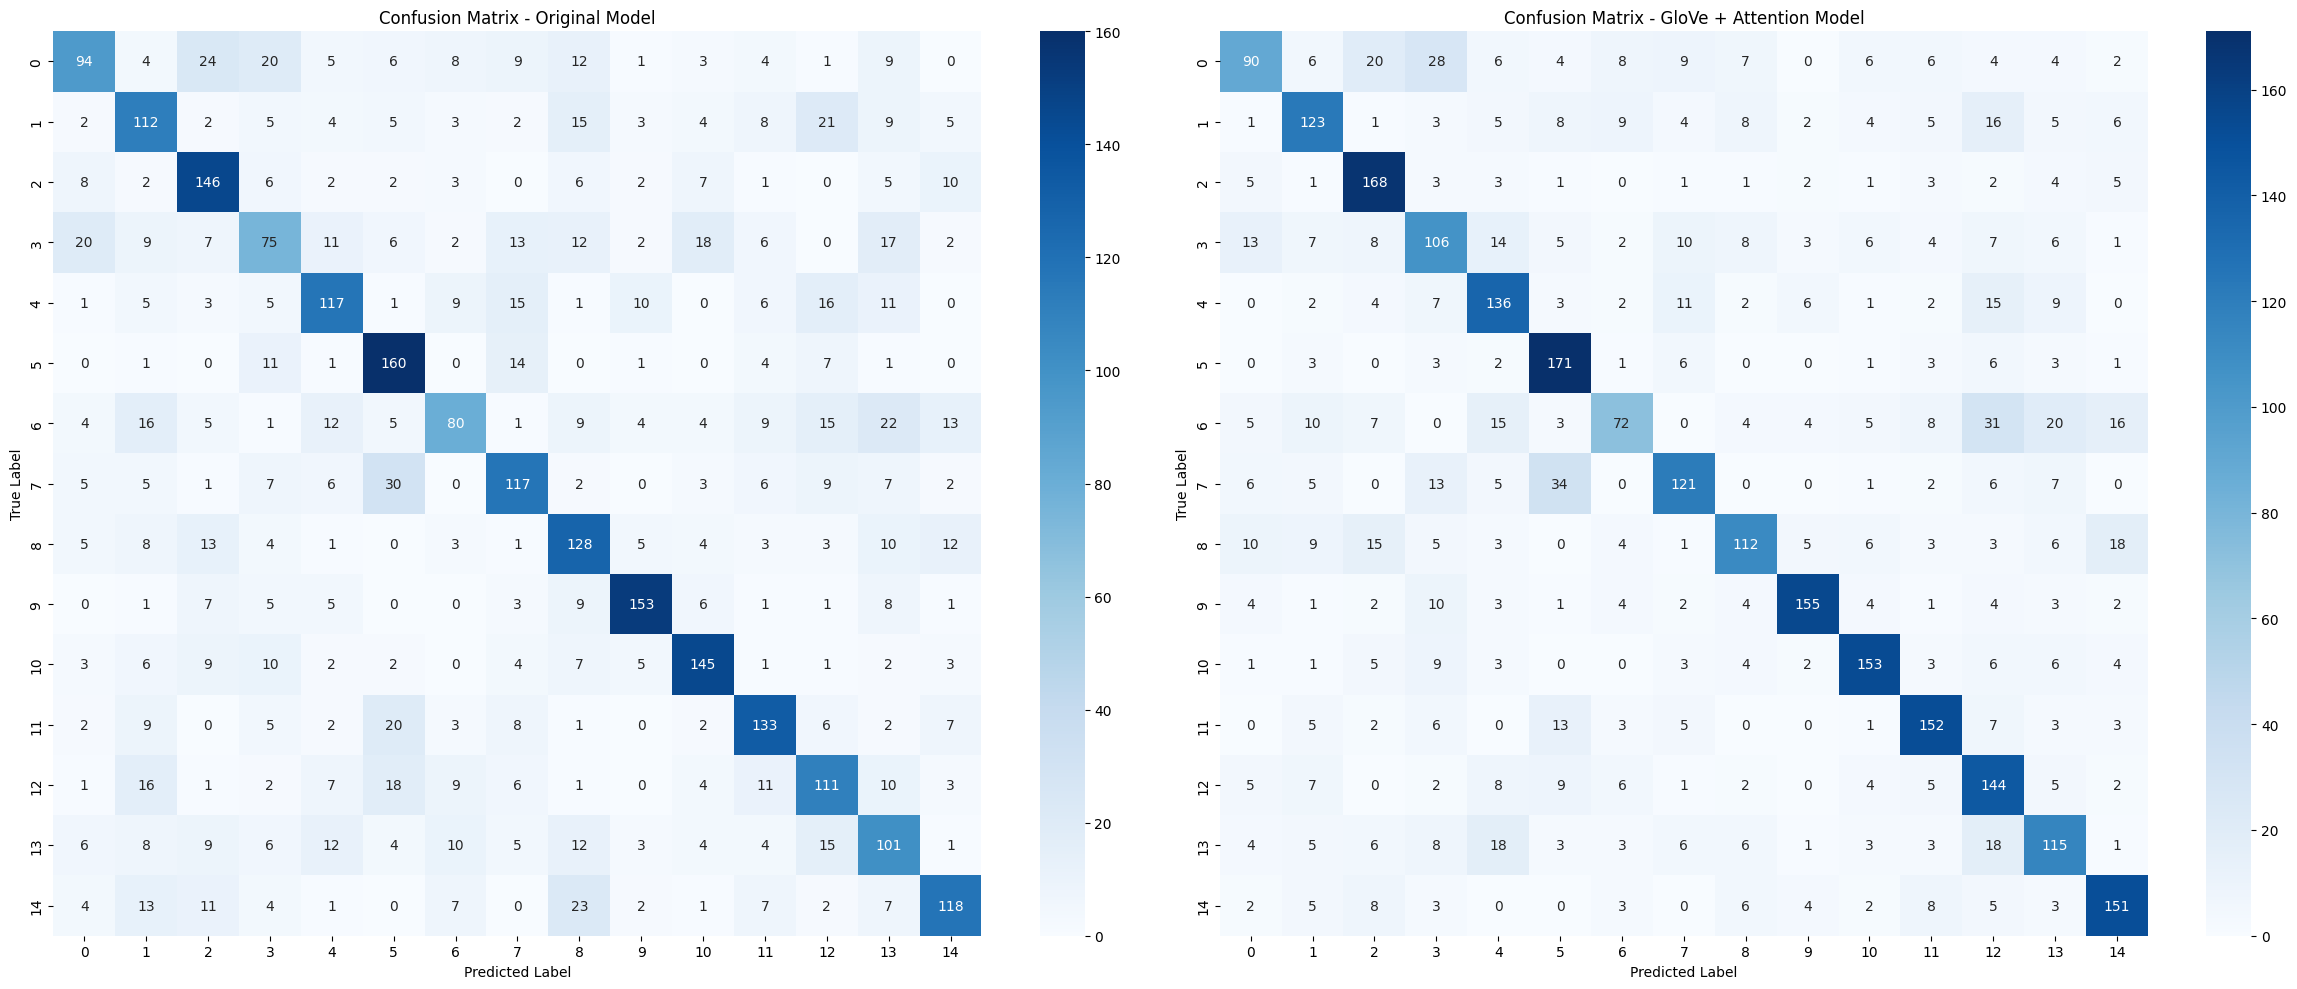

In [ ]:
# Generate confusion matrix for the original model
cm_original = confusion_matrix(y_test, y_pred)

# Generate confusion matrix for the new GloVe + Attention model
cm_glove_attention = confusion_matrix(y_test, y_pred_glove)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plot confusion matrix for the original model
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[0])
axes[0].set_title('Confusion Matrix - Original Model')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot confusion matrix for the new GloVe + Attention model
sns.heatmap(cm_glove_attention, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[1])
axes[1].set_title('Confusion Matrix - GloVe + Attention Model')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

## Conclusion


Summary of Model Performance Comparison:
---------------------------------------
Original Model Test Accuracy: 0.5967 (59.67%)
GloVe + Attention Model Test Accuracy: 0.6563 (65.63%)
Original Model Test Loss: 1.3774
GloVe + Attention Model Test Loss: 1.2000

Observations from Training History Plots:
- Both models show decreasing training loss and increasing training accuracy over epochs.
- The validation performance for both models plateaus relatively early, indicating that further training might lead to overfitting.
- The GloVe + Attention model seems to reach a slightly better validation accuracy and a lower validation loss compared to the original model before early stopping.

Observations from Classification Report Comparison (Precision, Recall, F1-score):
- The GloVe + Attention model generally shows improvements in precision, recall, and F1-score across many classes compared to the original model.
- Notable improvements in F1-score are observed for classes like BUSINESS, CRIME, ENTERTAINMENT, FAMILY, FOOD, LIFESTYLE, SPORTS, TRAVEL, WELLNESS, WOMEN, and WORLDPOST.
- Some classes like BLACK_VOICES and IMPACT show slight decreases or similar performance.
- The average macro and weighted average F1-scores are higher for the GloVe + Attention model (0.65 and 0.65) compared to the original model (0.59 and 0.59), indicating overall better balanced performance across classes.

Observations from Confusion Matrix Comparison:
- Both models show diagonal dominance, indicating they are correctly classifying a significant portion of samples.
- The off-diagonal values in the GloVe + Attention matrix appear generally lower than the original model, suggesting fewer misclassifications between different classes.
- Some classes that were frequently confused by the original model (e.g., ENTERTAINMENT with other classes) show reduced misclassification in the GloVe + Attention model.
- Conversely, the confusion matrix might reveal specific classes where the new model still struggles or makes new types of errors.

Conclusion:
The new model incorporating pre-trained GloVe embeddings and an attention layer demonstrates improved performance compared to the original HCNN model. The test accuracy increased from 59.67% to 65.63%, and the test loss decreased. The classification report and F1-score comparison plots show that this improvement is distributed across many, though not all, classes. The confusion matrices visually confirm a reduction in misclassifications for several categories.

Potential Reasons for Improvement:
- **Pre-trained GloVe Embeddings:** Using pre-trained embeddings allows the model to leverage knowledge about word relationships learned from a massive corpus, providing a richer initial representation than randomly initialized embeddings.
- **Attention Mechanism:** The attention layer helps the model focus on the most relevant parts of the input sequence when making predictions, potentially improving its ability to capture important features for classification, especially in longer texts.

Suggested Future Work:
- Experiment with different pre-trained embeddings (e.g., Word2Vec, FastText).
- Explore different attention mechanisms or incorporate attention at different points in the architecture.
- Fine-tune the pre-trained embeddings during training.
- Adjust hyperparameters (e.g., learning rate, batch size, dropout rates, number of filters, kernel sizes).
- Implement more complex model architectures (e.g., LSTMs or Transformers combined with CNNs).
- Investigate potential class imbalances or difficult-to-classify samples to understand specific areas for improvement.


## Future work

Suggested Future Work and Experimentation:
-------------------------------------------
1. Hyperparameter Tuning:
   - Experiment with different learning rates for the Adam optimizer.
   - Tune batch size to find the optimal balance between training speed and performance.
   - Adjust dropout rates in the embedding and dense layers to mitigate overfitting.
   - Explore different numbers of filters and kernel sizes in the Conv1D layers to capture different text patterns.

2. Exploring Different Architectures:
   - Implement and evaluate models based on Recurrent Neural Networks (RNNs), such as LSTMs or GRUs, which are effective for sequential data.
   - Investigate Transformer-based models (e.g., fine-tuning a pre-trained BERT or RoBERTa model) for potentially higher accuracy, although they are computationally more expensive.
   - Consider hybrid architectures that combine CNNs with RNNs or Attention mechanisms in different configurations.

3. Using Other Pre-trained Embeddings:
   - Experiment with other popular pre-trained word embeddings like Word2Vec or FastText to see if they provide better representations for this dataset.
   - Compare the performance when using different dimensions for the embedding vectors (e.g., 300d GloVe embeddings).

4. Fine-tuning Embeddings:
   - Make the pre-trained GloVe embedding layer trainable during model training to allow the model to adapt the embeddings to the specific dataset and task.

5. Addressing Class Performance Variations:
   - Based on the per-class metrics and confusion matrix, identify classes with lower performance.
   - Explore techniques to address potential class imbalance or difficulty, such as resampling (oversampling underrepresented classes or undersampling overrepresented ones) or using class weights in the loss function.

6. Error Analysis:
   - Perform a detailed analysis of misclassified samples from the test set.
   - Categorize the types of errors the model makes (e.g., confusing similar categories, struggling with short or long texts, sensitivity to specific keywords).
   - Use insights from error analysis to inform further model improvements or data preprocessing steps.

By exploring these areas, the model's performance for text classification can potentially be further enhanced.


## Summary:

### Data Analysis Key Findings

*   The new model, incorporating GloVe embeddings and an attention layer, achieved a test accuracy of 65.63%, which is an improvement over the original model's accuracy of 59.67%.
*   The new model also showed a lower test loss (1.2000) compared to the original model's test loss (1.3774).
*   Visual comparison of training history plots indicates that the new model reaches a slightly better validation accuracy and lower validation loss before early stopping.
*   Analysis of classification reports and F1-score plots shows that the performance improvement in the new model is distributed across many classes, with notable gains in categories like BUSINESS, CRIME, ENTERTAINMENT, FAMILY, FOOD, LIFESTYLE, SPORTS, TRAVEL, WELLNESS, WOMEN, and WORLDPOST.
*   The macro and weighted average F1-scores for the new model (0.65 and 0.65) are higher than the original model (0.59 and 0.59), indicating better overall balanced performance.
*   Confusion matrix comparison suggests that the new model makes fewer misclassifications between different classes compared to the original model.

### Insights or Next Steps

*   The use of pre-trained GloVe embeddings and an attention mechanism has successfully enhanced the model's ability to understand and classify text data, likely due to leveraging external word knowledge and focusing on relevant features.
*   Future work should focus on fine-tuning the model by experimenting with different hyperparameters, exploring more advanced architectures (like LSTMs or Transformers), and potentially fine-tuning the pre-trained embeddings to further improve performance, especially for classes where the new model did not show significant improvement.
